# Representing tissue-specific genes using Saliency 
This notebook illustrates how to extract saliency maps from a model designed to predict labels of bulk RNA-seq samples.\
The result product is a matrix where each colunm is a label (tissue) and the rows are genes which serves as input fed to the model.\
The values of the matrix represents the level of impact of each gene on predicting each label. 

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from data import get_url_label_set, get_data_from_url, get_input_filter 
from net import Net
import sys


## loading and preparing sample data and model

In [7]:
input_filter_path = r"./additional_files/gencode.v26.GRCh38.protein_coding_genes.csv.gz"
output_dir = r"outputs"

In [8]:
label_set = get_url_label_set()
df_pc = pd.read_csv(input_filter_path, compression="gzip")
input_filter = set(df_pc['transcript_id'].to_list())

In [9]:
print("This takes a few moments")
x_data, y_data, cat_dict = get_data_from_url(label_set=label_set,
                                              n_samples_min=0, 
                                              verbose=False,
                                              input_filter=input_filter,
                                              rand_test_sample=True)        # set True for this script

This takes a few moments
bad url (<Response [404]>) at label: cells_leukemia_cell_line_cml
Done loading data!
No. of categories: 54


In [10]:
x_data.shape

(1080, 19291)

In [13]:
model_path = r"/mnt/c/Users/User/python_files/GTEx_RNASeq_DL/run_eval_drop.5_1/best_checkpoint.pth"
dev = "cuda:0" # or "cpu"
param_list = [19291,7000, 2916, 540, 54]  # specification of layers of the loaded Net should be identical to the saved one!! 

model = Net(param_list)
state_dict = torch.load(model_path, weights_only=True)
model.load_state_dict(state_dict['model_state_dict'])
model.to(dev)

Net(
  (linear1): Linear(in_features=19291, out_features=7000, bias=True)
  (linear2): Linear(in_features=7000, out_features=2916, bias=True)
  (linear3): Linear(in_features=2916, out_features=540, bias=True)
  (linear4): Linear(in_features=540, out_features=54, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
def prepare_raw_input(x, dev):
    # converting sample to tensors and moving to model's device
    x = torch.from_numpy(x)
    x = x.float().to(dev)
    return x

## Defining  and calling the Saliency function

In [14]:
def saliency(x, abs=False):
    for param in model.parameters():
        param.requires_grad = False
        
    model.eval()
    
    x.requires_grad = True # keeping track on samples gradient
    preds = model(x)
    score, indices = torch.max(preds, 0) 
    
    score.backward() #backward pass to get gradients of score predicted class w.r.t. input image
    if abs:
        slc = torch.abs(x.grad) 
    else:
        slc = x.grad
        
    
    slc = (slc - slc.min())/(slc.max()-slc.min()) #normalize to [0..1]
    return slc
    

In [15]:
x = prepare_raw_input(x_data, dev)
y_pred = model(x) # predict given samples

In [16]:
y_pred = torch.argmax(y_pred.data, 1).to("cpu").numpy() # get predicted labels 

In [18]:
sal_dict = dict()

# extracting saliency values for all input genes, for each tissue.
for cat, cat_str in cat_dict.items():
    y_pos = np.where((y_data == y_pred) & (y_data == cat))[0] # get correctley predicted sample for corresponding label 
    # print(f'{cat_str}: idx: {y_pos[0]}')
    x_pos = x_data[y_pos[0]]
    x_pos = prepare_raw_input(x_pos, dev) 
    sal = saliency(x_pos) # extract saliency map based on selected predicted sample
    sal_dict[cat_str] = sal.to("cpu").numpy() # collect saliency maps of each tissue

In [19]:
df_sal = pd.DataFrame(sal_dict)
df_sal = df_sal.merge(df_pc['gene_name'], left_index=True, right_index=True).set_index('gene_name')

In [20]:
df_sal

,whole_blood,brain_frontal_cortex_ba9,adipose_subcutaneous,muscle_skeletal,artery_tibial,artery_coronary,heart_atrial_appendage,adipose_visceral_omentum,ovary,uterus,...,brain_hippocampus,brain_anterior_cingulate_cortex_ba24,brain_substantia_nigra,kidney_cortex,brain_amygdala,cervix_ectocervix,fallopian_tube,cervix_endocervix,bladder,kidney_medulla
gene_name,,,,,,,,,,,,,,,,,,,,,
OR4F5,0.584014,0.441327,0.477842,0.445016,0.400896,0.441760,0.324662,0.383456,0.567257,0.470409,...,0.367502,0.344922,0.431708,0.527095,0.391358,0.489516,0.311253,0.561346,0.376426,0.441328
OR4F29,0.568212,0.435053,0.471248,0.442596,0.398171,0.455428,0.331536,0.393414,0.573541,0.474631,...,0.373130,0.347805,0.435076,0.522337,0.395369,0.487251,0.329425,0.555513,0.372388,0.444793
OR4F16,0.579654,0.438095,0.480254,0.456238,0.401644,0.445806,0.327286,0.386509,0.562329,0.475180,...,0.370135,0.347237,0.434637,0.525444,0.394704,0.487197,0.313914,0.559264,0.368082,0.441866
SAMD11,0.565163,0.419994,0.463956,0.411981,0.395605,0.385766,0.365329,0.428295,0.545156,0.470327,...,0.367621,0.307430,0.421186,0.544843,0.373707,0.483728,0.350484,0.476169,0.418956,0.439434
NOC2L,0.524033,0.391995,0.549659,0.603716,0.496249,0.470238,0.261061,0.351708,0.522262,0.501157,...,0.392641,0.396888,0.457352,0.408814,0.483686,0.487047,0.341161,0.485862,0.451063,0.494043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,0.639764,0.356199,0.529624,0.560286,0.441015,0.439484,0.440477,0.378339,0.511684,0.496772,...,0.363842,0.341345,0.374734,0.534343,0.360925,0.507320,0.279106,0.511141,0.465501,0.344325
MT-ND4,0.545825,0.438504,0.492542,0.469504,0.406140,0.420573,0.345858,0.359364,0.585414,0.476665,...,0.372175,0.342468,0.437339,0.520287,0.384710,0.493410,0.302973,0.563150,0.398371,0.432889
MT-ND5,0.599697,0.422454,0.379163,0.355811,0.385317,0.457428,0.329344,0.469204,0.551789,0.421521,...,0.372598,0.340296,0.428696,0.508470,0.375315,0.439117,0.473292,0.555781,0.400329,0.452340


# Example: genes with high imapct on predicting of Pancreas tissue
The segment below illustrate the concept of saliency map for Pancreas tissue, in a visual manner.

In [24]:
tissue_idx = 19
print(f"sorted Saliency values for {cat_dict[tissue_idx]}:")
df_sal[cat_dict[tissue_idx]].sort_values(ascending=False)

sorted Saliency values for pancreas:


gene_name
SLC6A11    1.000000
AVP        0.981376
REG1A      0.965179
PGGHG      0.944837
PEG10      0.937129
             ...   
OPALIN     0.206320
KIF5A      0.181102
COMP       0.135939
CFH        0.134360
RAPGEF4    0.000000
Name: pancreas, Length: 19291, dtype: float32

In [25]:
# selecting genes with highest values in tissue's saliency map
top_genes = df_sal[cat_dict[tissue_idx]].sort_values(ascending=False).head(20) 

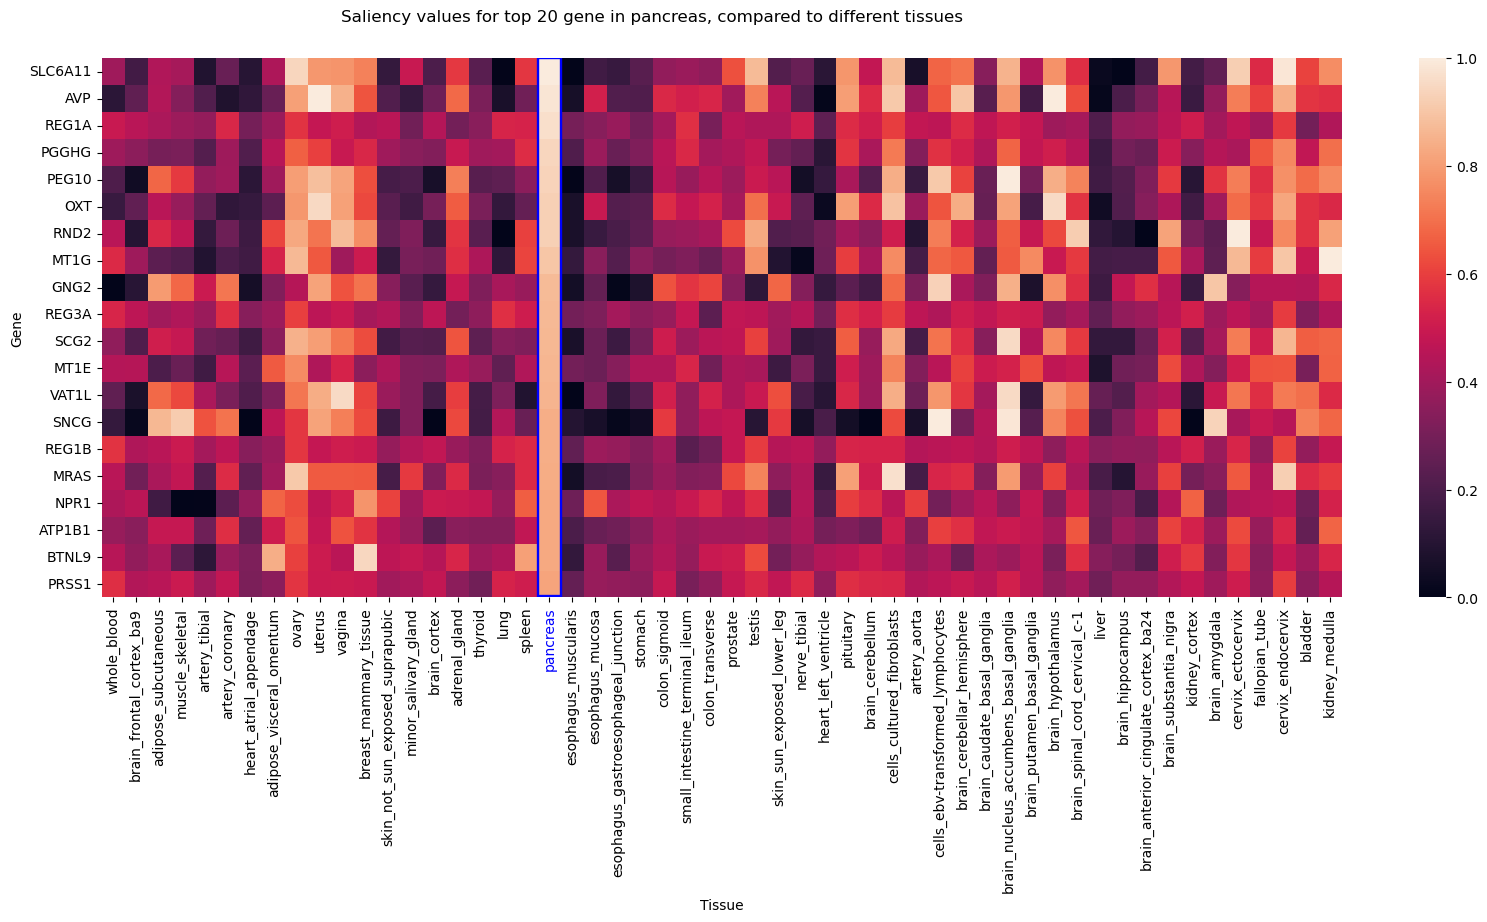

In [26]:
fig_name = "saliency_heatmap.png"

fig,ax = plt.subplots(figsize=(20,7))

sns.heatmap(df_sal.loc[top_genes.index], ax=ax)
ax.xaxis.get_ticklabels()[tissue_idx].set_color('blue')
ax.add_patch(patches.Rectangle((tissue_idx, 0),1.0,19.95,edgecolor='blue',fill=False,lw=1.7))
ax.set_ylabel('Gene')
ax.set_xlabel('Tissue')
tissue_str = cat_dict[tissue_idx]
fig.suptitle(f"Saliency values for top 20 gene in {tissue_str.strip("_")}, compared to different tissues",x=0.4, y=0.95)
# fig.savefig(os.path.join(output_dir, fig_name), bbox_inches='tight', format='png') 
plt.show()

The heatmap above visualizes the saliency values of the top 20 genes most influential in predicting Pancreas tissue, compared across different tissue types.

 - The x-axis represents various tissue types, including Pancreas (highlighted in blue).
 - The y-axis lists the top 20 genes ranked by their impact on the model's pancreas classification.
 - The color intensity indicates the saliency value, where lighter colors (closer to white) represent higher importance, while darker colors (black/purple) indicate lower saliency.
   
From the heatmap, it is evident that the selected genes exhibit distinctly higher saliency values in Pancreas, supporting their relevance to the model’s prediction. In contrast, their influence in other tissues is more varied, reinforcing the idea that tissue-specific gene importance is not solely determined by expression levels, but by learned patterns in the model.

```
```
# Examination of Expression Levels vs. Saliency
Traditional transcriptomic analysis primarily focuses on gene expression levels, assuming that genes with either high or low expression in a given context play a key role in defining a system’s state. Highly expressed genes are often considered essential drivers of biological processes, while under-expressed (repressed) genes may indicate regulatory suppression or shifts in cellular function.

However, relying solely on expression levels to infer regulatory networks is limiting, as it overlooks the complex interactions between genes, which neural networks inherently capture.

In the following segment, it is demonstrated that for a specific tissue, the genes with the highest impact on model predictions are not necessarily those with the most distinct expression levels. 

Below are three genes with high saliency values in Pancreas, and their expression across all labels (Pancreas label colored blue).

In [27]:
exp_dict

{}

In [37]:
def plot_cross_tissue_expression(gene, tissue_str):
    exp_dict = dict() # collecting expression of selected set across all samples
    gene_idx = df_pc[df_pc['gene_name'] == gene].index[0]
    
    for cat_i, cat_str in cat_dict.items(): 
        cat_idx = np.where(y_data == cat_i)
        exp_dict[cat_str] = x_data.T[gene_idx][cat_idx] 

    df1 = pd.DataFrame.from_dict(exp_dict)
    df1 = df1.melt().rename(columns={"variable":"Tissue","value":"normalized expression"})
    order = df1.groupby("Tissue")['normalized expression'].mean().sort_values(ascending=False).index # sorting tissues by their mean expression of the given gene 
    my_pal = {tissue: "r" if tissue == tissue_str else "b" for tissue in df1['Tissue'].unique()} # coloring selected tissue box
    
    sns.set_theme('paper')
    fig, ax = plt.subplots(figsize=(15,7))
    sns.boxplot(df1, x="Tissue", y="normalized expression", order=order, hue='Tissue',palette=my_pal, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    
    for j, ticklbl in enumerate(ax.xaxis.get_ticklabels()): # highlighting the origin tissue, from which the given gene was selected due to high saliency value
        if ticklbl.get_text() == tissue_str:
            ticklbl.set_color('blue')
    sal_val = f"{top_genes.loc[gene]:.3f}"  # selected gene saliency value
    title = f"normalized expression of gene {gene} with saliency value: {sal_val} in {tissue_str}, across all labels"  
    plt.suptitle(title,y=0.95)
    plt.show()
    # return exp_dict

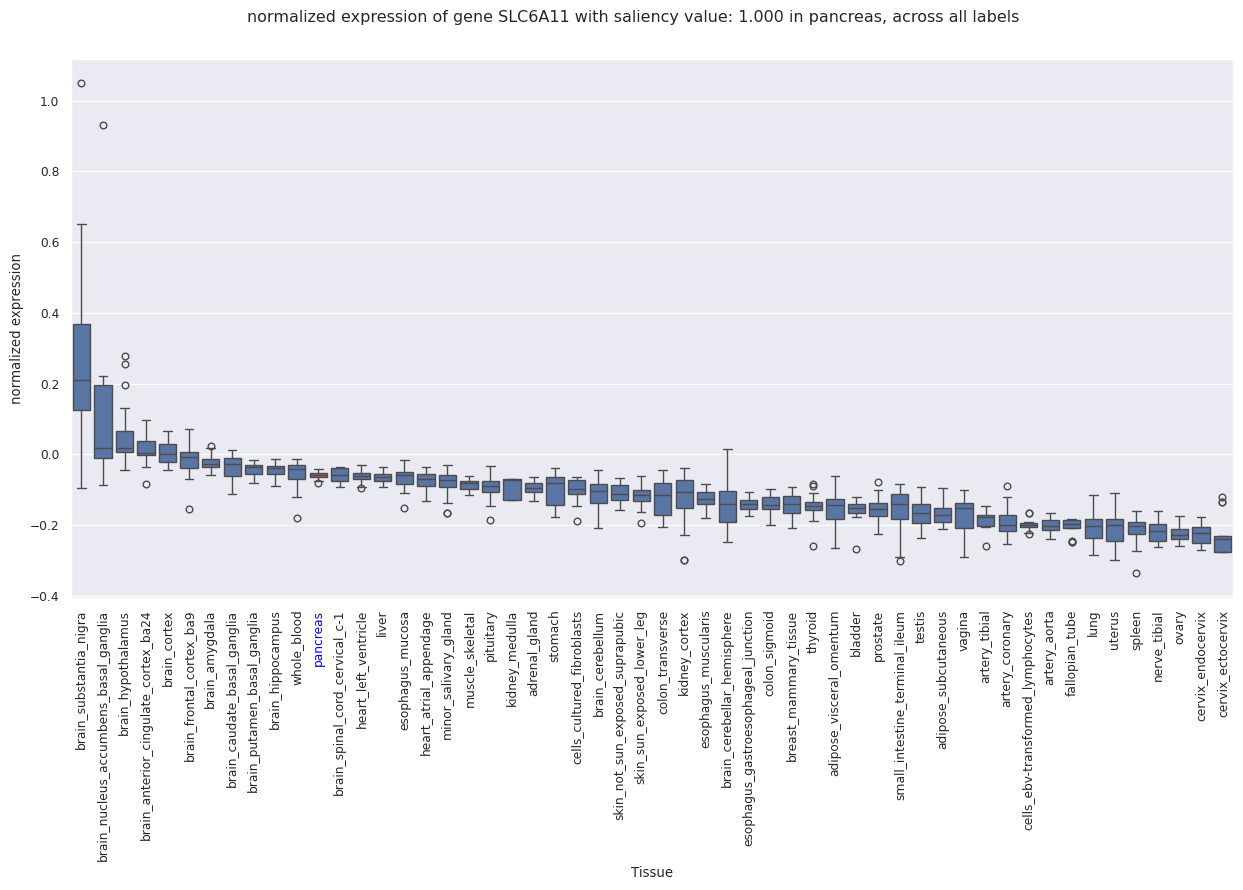

In [47]:
gene1 = top_genes.index[0] 
plot_cross_tissue_expression(gene1, tissue_str) # plot normalized expression of a gene across the different labels

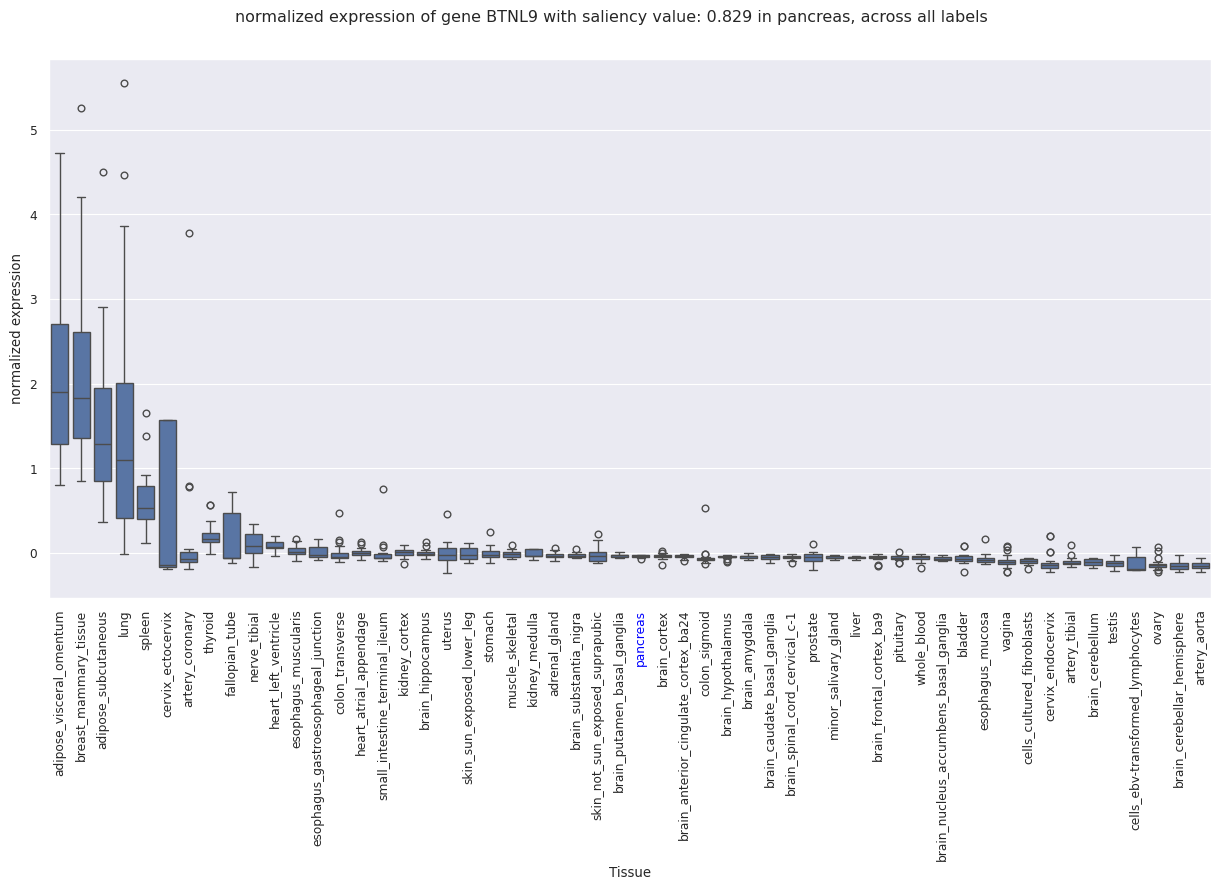

In [53]:
gene2 = top_genes.index[18] 
plot_cross_tissue_expression(gene2, tissue_str)

While high expression is not always the main factor driving saliency, in some cases, genes with naturally high expression levels in a given tissue do play a key role in distinguishing it from others. This suggests that while deep learning uncovers hidden patterns beyond raw expression levels, some highly expressed genes remain biologically relevant markers of tissue identity.

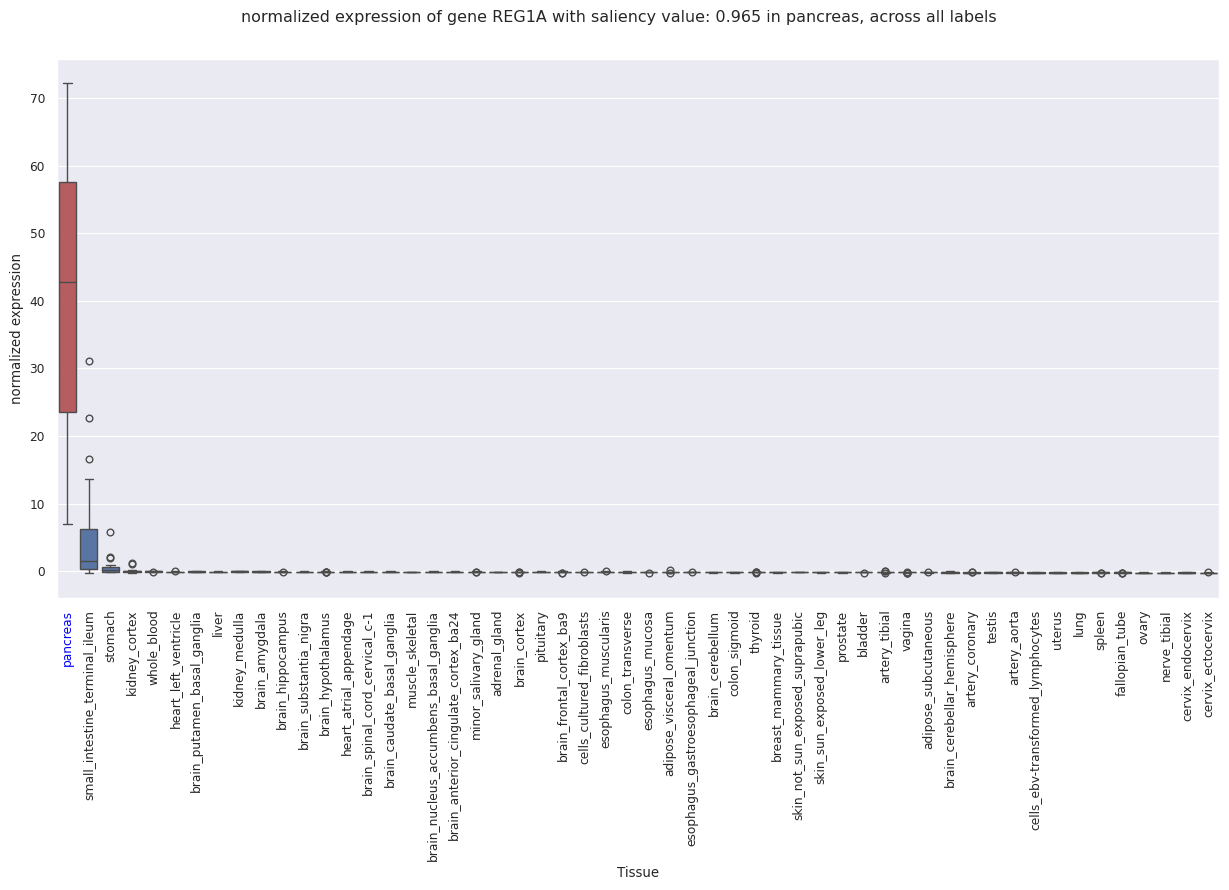

In [40]:
gene3 = top_genes.index[2]  
plot_cross_tissue_expression(gene3, tissue_str)

In [1]:
# # gene_means = np.log(x_data.mean(axis=0))
# # gene_std = np.log(x_data.std(axis=0))
# gene_means = np.log(cat_data.mean(axis=0))
# gene_std = np.log(cat_data.std(axis=0))
# gene_sal = df_sal[tissue_str].to_list()

# sns.scatterplot(y=gene_sal, x=gene_std, hue=gene_means, palette='viridis')